In [1]:
! pip install torch_geometric
! pip install rdkit
! pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 17.7 MB/s eta 0:00:00


In [3]:
import os
from sklearn.model_selection import train_test_split
import torch
import torch_geometric

bace = torch_geometric.datasets.MoleculeNet("./data/", name='BACE')
train_data, test_valid_data  = train_test_split(bace, test_size=0.2, random_state=42)
test_data, valid_data = train_test_split(test_valid_data , test_size=0.5, random_state=42)

# Define the paths to save the splits
save_path = './data/splits'
os.makedirs(save_path, exist_ok=True)

train_path = os.path.join(save_path, 'train.pt')
test_path = os.path.join(save_path, 'test.pt')
valid_path = os.path.join(save_path, 'valid.pt')

# Save the splits
torch.save(train_data, train_path)
torch.save(test_data, test_path)
torch.save(valid_data, valid_path)
print(bace[0])

num_features = bace.num_features
num_classes = bace.num_classes

Processing...


KeyboardInterrupt: 

In [2]:
import numpy as np
import torch
import torch_geometric

bace = torch_geometric.datasets.MoleculeNet("./data/", name='BACE')
num_features = bace.num_features
num_classes = bace.num_classes
path = './data/splits/'
train_data = torch.load(f'{path}train.pt')
test_data = torch.load(f'{path}test.pt')
valid_data = torch.load(f'{path}valid.pt')


Processing...
Done!


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import pytorch_lightning as pl
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, TransformerConv, GATConv,GATv2Conv, NNConv, CGConv, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
BATCH_SIZE = 4
from torchmetrics import MeanAbsoluteError

class GNN(pl.LightningModule):
    def __init__(self, num_features, embedding_size, num_layers, pos_weight, mlp=False, hidden_size_mlp=4):
        super(GNN, self).__init__()
        self.criterion = nn.CrossEntropyLoss(weight=pos_weight)

        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        hidden_channels = 128
        for i in range(num_layers):
            self.convs.append(GCNConv(
                num_features if i == 0 else hidden_channels,
                hidden_channels if i < num_layers - 1 else embedding_size,
                # edge_dim=4
                ))

        # Output layer
        if mlp:
          self.out = nn.Sequential(
              nn.Linear(embedding_size, hidden_size_mlp),
              nn.ReLU(),
              nn.Linear(hidden_size_mlp, 2)
          )
        else:
            self.out = nn.Sequential(
                nn.Linear(embedding_size, 2))

    def forward(self, data):
        x = data.x.float()
        edge_index = data.edge_index
        edge_attr = data.edge_attr

        for i, conv in enumerate(self.convs):
            x = conv(x.float(), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()

        hidden = gmp(x, data.batch)
        out = self.out(hidden)
        return out, hidden

    def training_step(self, data, batch_idx):
        logits, h = self(data)
        loss = self.criterion(logits, data.y.squeeze(1).long())
        self.log("train_loss", loss, batch_size=BATCH_SIZE, prog_bar=True,on_epoch=True,  logger=True)
        accuracy = (torch.argmax(logits, 1) == data.y).float().mean()
        self.log('test_accuracy', accuracy, batch_size=BATCH_SIZE, prog_bar=True, on_epoch=True, logger=True)
        return loss


    def validation_step(self, data, batch_idx):
        logits, h = self(data)
        loss = self.criterion(logits, data.y.squeeze(1).long())
        self.log("valid_loss", loss, batch_size=BATCH_SIZE, prog_bar=True, on_epoch=True, logger=True)
        accuracy = (torch.argmax(logits, 1) == data.y).float().mean()
        self.log('valid_accuracy', accuracy,  batch_size=BATCH_SIZE, prog_bar=True, on_epoch=True, logger=True)
        return loss

    def test_step(self, data, batch_idx):
        logits, h = self(data)
        loss = self.criterion(logits, data.y.squeeze(1).long())
        self.log("test_loss", loss, batch_size=BATCH_SIZE, prog_bar=True, on_epoch=True, logger=True)
        accuracy = (torch.argmax(logits, 1) == data.y).float().mean()
        self.log('test_accuracy', accuracy,  batch_size=BATCH_SIZE, prog_bar=True, on_epoch=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [38]:
import torch
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pytorch_lightning as pl
from torchsummary import summary
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

csv_logger = CSVLogger(
    save_dir='./',
    name='csv_file'
)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True,num_workers=3, persistent_workers=True)
valid_loader = DataLoader(valid_data, batch_size=64,num_workers=3,persistent_workers=True)

class_0 = [ i for i in train_data if i.y[0] == 0 ]
num_class_0 = len(class_0)
weight_0 = len(train_data) / (2 * num_class_0)
class_1 = [ i for i in train_data if i.y[0] == 1 ]
num_class_1 = len(class_1)
weight_1 = len(train_data) / (2 * num_class_1)

logger = TensorBoardLogger("logs", name="gnn")
hidden_size = 4
embedding_size = [1, 2, 64]
model = GNN(num_features, embedding_size=embedding_size[0], pos_weight=torch.tensor([weight_0, weight_1]), num_layers=5, mlp=True, hidden_size_mlp=hidden_size)
print(model)
trainer = pl.Trainer(max_epochs=1000,  callbacks=[EarlyStopping(monitor='valid_loss')], logger=csv_logger)
trainer.fit(model,
            train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

torch.save(model.state_dict(), 'gnn_classification.pth')

test_loader = DataLoader(test_data, batch_size=64)
trainer.test(model, test_loader)

GNN(
  (criterion): CrossEntropyLoss()
  (convs): ModuleList(
    (0): GCNConv(9, 128)
    (1-3): 3 x GCNConv(128, 128)
    (4): GCNConv(128, 1)
  )
  (out): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Class 0: Precision=0.7, Recall=0.5121951219512195, F1 Score=0.5915492957746479, Support=82
Class 1: Precision=0.5604395604395604, Recall=0.7391304347826086, F1 Score=0.6375, Support=69
Test Accuracy: 0.6159


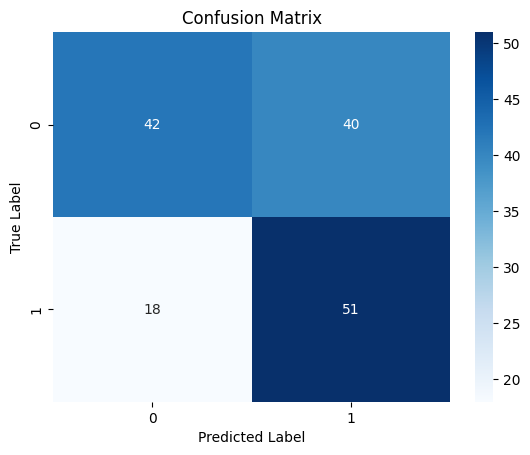

In [12]:
import torchmetrics
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
predictions, targets = [], []

with torch.no_grad():
    for batch in test_loader:
        output, h = model(batch)
        predictions.extend(output.argmax(dim=1).cpu().numpy())
        targets.extend(batch.y.cpu().numpy())

accuracy = accuracy_score(targets, predictions)
precision, recall, fscore, support = precision_recall_fscore_support(targets, predictions, average=None)
for i in range(len(precision)):
    print(f"Class {i}: Precision={precision[i]}, Recall={recall[i]}, F1 Score={fscore[i]}, Support={support[i]}")
print(f'Test Accuracy: {accuracy:.4f}')
matrix = torchmetrics.ConfusionMatrix(task = 'binary')
y_true_tensor = torch.tensor(targets)
y_pred_tensor = torch.tensor(predictions).view(-1, 1)
conf_matrix = matrix(y_pred_tensor, y_true_tensor)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

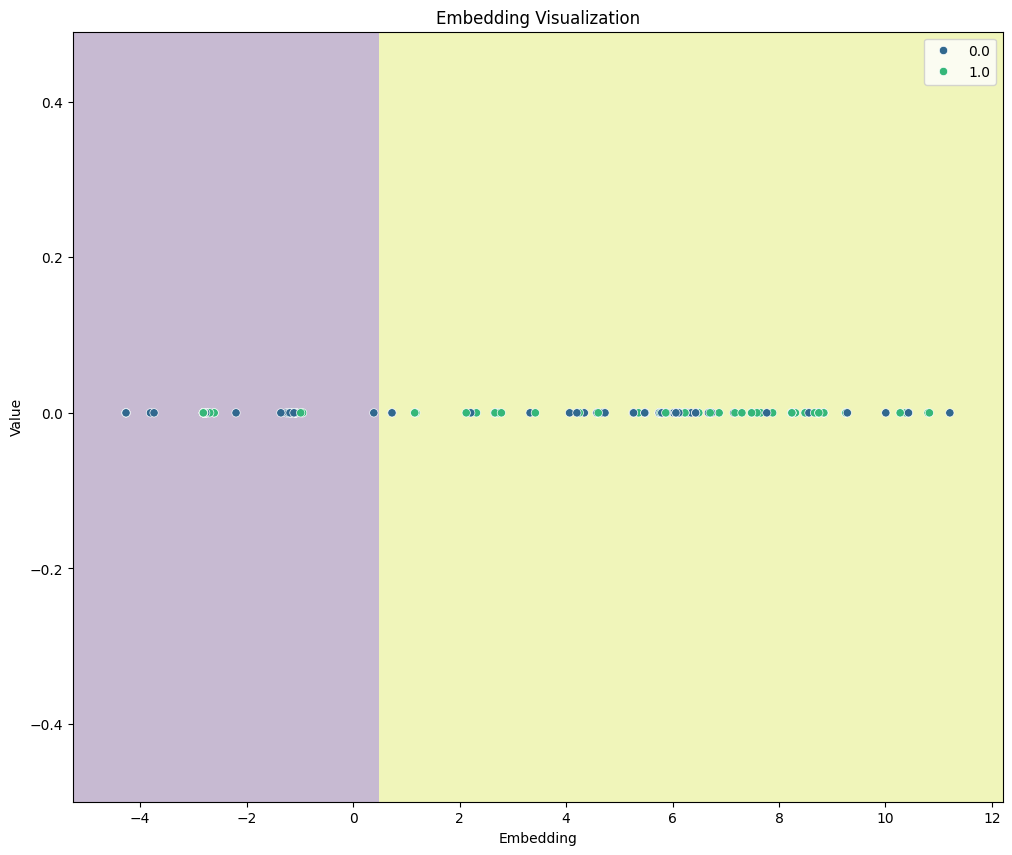

In [49]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification

def visualize1(model, lin):
    model.eval()
    test_loader = DataLoader(test_data, batch_size=64)
    reals,embeddings, outputs = [], [], []

    for batch in test_loader:
        # batch = batch.to(device)
        output, h = model(batch)
        outputs.extend(output.cpu().detach().numpy())
        reals.extend(batch.y.cpu().numpy())
        embeddings.extend(h.cpu().detach().numpy())

    plt.figure(figsize=(12, 10))
    embeddings = np.array(embeddings)
    outputs = np.array(outputs)
    reals = np.array(reals)
    if embeddings.shape[1] == 1:
      embedded_space = embeddings
    else:
      tsne = TSNE(n_components=1, random_state=42)
      embedded_space = tsne.fit_transform(embeddings)

    x_min, x_max = embedded_space[:, 0].min() - 1, embedded_space[:, 0].max() + 1
    y_min, y_max = -0.5, 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    meshgrid_points = np.c_[xx.ravel()]
    meshgrid_points_tensor = torch.FloatTensor(meshgrid_points)
    with torch.no_grad():
      if lin:
        linear_layer = torch.nn.Linear(1, 2)
        predictions = linear_layer(meshgrid_points_tensor)
      else:
        linear_layer = torch.nn.Linear(1, 4)
        nl_layer = nn.ReLU()
        lin2_layer = nn.Linear(4, 2)
        with torch.no_grad():
          predictions = linear_layer(meshgrid_points_tensor)
          predictions = nl_layer(predictions)
          predictions = lin2_layer(predictions)
    outputs = torch.tensor(outputs)
    predictions = predictions.argmax(dim=1).cpu().numpy()
    predictions = predictions.reshape(xx.shape)
    plt.contourf(xx, yy, predictions, alpha=0.3, cmap='viridis')
    scatter = sns.scatterplot(x=embeddings.flatten(),  y=np.zeros_like(embeddings.flatten()), hue=reals.flatten(), palette='viridis')
    plt.title('Embedding Visualization')
    plt.xlabel('Embedding')
    plt.ylabel('Value')
    plt.legend()

    plt.show()

model.load_state_dict(torch.load(r'/content/gnn_classification_mlp_1.pth'))
visualize1(model, False)


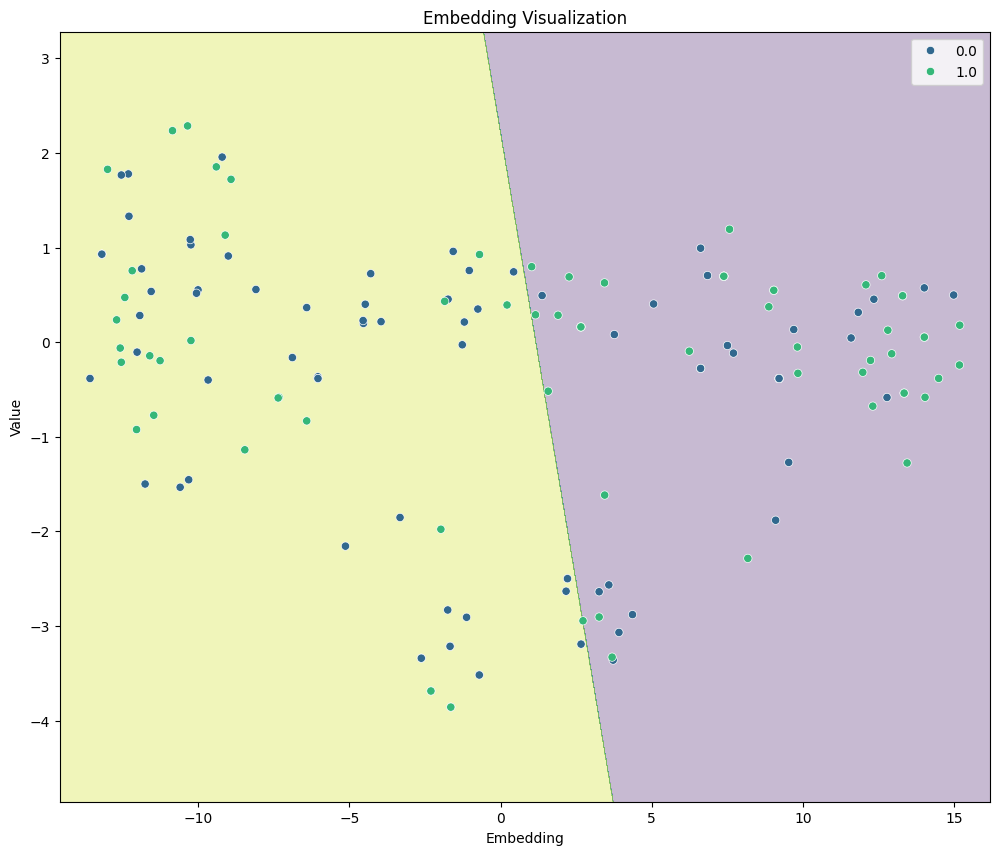

In [19]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification

def visualize2(model, lin):
    model.eval()
    test_loader = DataLoader(test_data, batch_size=64)
    reals,embeddings, outputs = [], [], []

    for batch in test_loader:
        # batch = batch.to(device)
        output, h = model(batch)
        outputs.extend(output.cpu().detach().numpy())
        reals.extend(batch.y.cpu().numpy())
        embeddings.extend(h.cpu().detach().numpy())

    plt.figure(figsize=(12, 10))
    embeddings = np.array(embeddings)
    outputs = np.array(outputs)
    reals = np.array(reals)
    if embeddings.shape[1] == 2:
      embedded_space = embeddings
    else:
      tsne = TSNE(n_components=2, random_state=42)
      embedded_space = tsne.fit_transform(embeddings)

    h = .01
    x_min, x_max = embedded_space[:, 0].min() - 1, embedded_space[:, 0].max() + 1
    y_min, y_max = embedded_space[:, 1].min() - 1, embedded_space[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    meshgrid_points = np.c_[xx.ravel(), yy.ravel()]
    meshgrid_points_tensor = torch.FloatTensor(meshgrid_points)

    if lin:
        linear_layer = torch.nn.Linear(2, 2)
        with torch.no_grad():
          predictions = linear_layer(meshgrid_points_tensor)
    else:
        linear_layer = torch.nn.Linear(2, 4)
        nl_layer = nn.ReLU()
        lin2_layer = nn.Linear(4, 2)
        with torch.no_grad():
          predictions = linear_layer(meshgrid_points_tensor)
          predictions = nl_layer(predictions)
          predictions = lin2_layer(predictions)

    predictions = predictions.argmax(dim=1).cpu().numpy()
    predictions = predictions.reshape(xx.shape)

    plt.contourf(xx, yy, predictions, alpha=0.3, cmap='viridis')
    scatter = sns.scatterplot(x=embedded_space[:, 0], y=embedded_space[:, 1], hue=reals.flatten(), palette='viridis')
    plt.title('Embedding Visualization')
    plt.xlabel('Embedding')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

model.load_state_dict(torch.load(r'/content/gnn_classification_lin_22.pth'))
visualize2(model, lin=True)
